In [1]:
# Parser for Passatutto data
import sys
sys.path.append('C:\\Users\\Gosia\\Desktop\\FDR-Metabolomics\\src\\')
import passatutto_parser as pp

In [2]:
# Taking all the files from MassBankOrbi (queries) and parsing them to json objects
pre_spectrums_query = pp.PassatuttoParser(r'C:\\Users\\Gosia\\Desktop\\MassbankOrbi').parse_folder()

processed 100 files
processed 200 files
processed 300 files
processed 400 files
Finished parsing of 458 spectra 


In [3]:
# Taking all files from Gnps (library) and parsing them to json objects
pre_spectrums_lib = pp.PassatuttoParser('C:\\Users\\Gosia\\Desktop\\Gnps').parse_folder()

processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files
processed 4100 files
Finished parsing of 4138 spectra 


In [4]:
# Taking all files from decoys and parsing them to json objects
pre_spectrums_decoys_cond = pp.DecoyParserPassattuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyConditionalPeaks').parse_folder()
pre_spectrums_decoys_rand = pp.DecoyParserPassattuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyRandomPeaks').parse_folder()

processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files
processed 4100 files
Finished parsing of 4138 spectra 
processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 

In [5]:
# Using MatchMS to create spectra for both
from matchms.importing.load_from_json import as_spectrum
spectrums_query = []
for i, s in enumerate( pre_spectrums_query ):
    spectrums_query.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
spectrums_lib = []
for i, s in enumerate( pre_spectrums_lib ):
    spectrums_lib.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)

processed 100
processed 200
processed 300
processed 400
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
processed 1700
processed 1800
processed 1900
processed 2000
processed 2100
processed 2200
processed 2300
processed 2400
processed 2500
processed 2600
processed 2700
processed 2800
processed 2900
processed 3000
processed 3100
processed 3200
processed 3300
processed 3400
processed 3500
processed 3600
processed 3700
processed 3800
processed 3900
processed 4000
processed 4100


In [6]:
# Using MatchMS to create decoy spectra
decoys_cond = []
for i, s in enumerate( pre_spectrums_decoys_cond ):
    decoys_cond.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)

decoys_rand = []
for i, s in enumerate( pre_spectrums_decoys_rand ):
    decoys_rand.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)


processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
processed 1700
processed 1800
processed 1900
processed 2000
processed 2100
processed 2200
processed 2300
processed 2400
processed 2500
processed 2600
processed 2700
processed 2800
processed 2900
processed 3000
processed 3100
processed 3200
processed 3300
processed 3400
processed 3500
processed 3600
processed 3700
processed 3800
processed 3900
processed 4000
processed 4100
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
processed 1700
processed 1800
processed 1900
processed 2000
processed 2100
processed 2200
processed 2300
processed 2400
processed 2500
processed 2600
processed 270

In [7]:
# Calculating cosine similarity for target-query match
from cosine_calc import get_hits
hits = get_hits(spectrums_query, spectrums_lib, 3, cosine_tol=0.005, passatutto=True)

In [8]:
from rdkit.Chem import MolFromSmiles, MolToSmiles, MolFromInchi
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula
def add_pmz(specs):
    for s in specs:
        s.set('precursor_mz', s.get('parent_mass', 0))

add_pmz(spectrums_query)

In [9]:
# Calculating cosine similarity for query-decoy match
from cosine_calc import get_hits
hits_decoys_cond = get_hits(spectrums_query, decoys_cond, 3, "precursor_mz", cosine_tol=0.005, decoys=True, passatutto=True)
hits_decoys_rand = get_hits(spectrums_query, decoys_rand, 3, "precursor_mz", cosine_tol=0.005, decoys=True, passatutto=True)


In [10]:
print(len(hits))
print(len(hits_decoys_cond))
print(len(hits_decoys_rand))

286
280
297


In [11]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [12]:
# Calculating estimated q-value scores
q_list_estimated_cond = calculate_q_value(hits+hits_decoys_cond,True)
q_list_estimated_rand = calculate_q_value(hits+hits_decoys_rand,True)

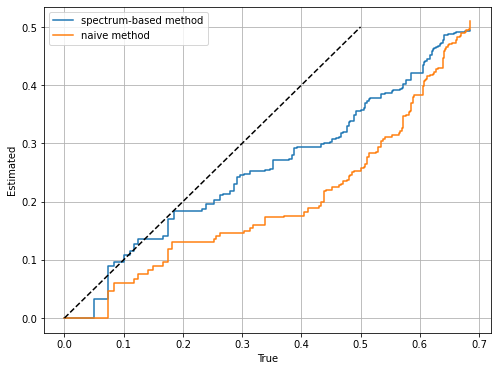

In [13]:
import plot_q_vals

# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
scores_cond, trues_cond, estimateds_cond = zip(*combine_true_est(q_list_true, q_list_estimated_cond))
scores_rand, trues_rand, estimateds_rand = zip(*combine_true_est(q_list_true, q_list_estimated_rand))

plot_q_vals.plot_q_vals( {'spectrum-based method':(trues_cond,estimateds_cond), 'naive method':(trues_rand,estimateds_rand)} )